In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import math
from IPython import display
import time

In [2]:
# !pip install efficientnet_pytorch
# !pip install torchsummary seaborn transformers albumentations

# torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn #conv2d 
from torchvision import transforms, models
from efficientnet_pytorch import EfficientNet
from torchsummary import summary

import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.special import softmax

from transformers import get_cosine_schedule_with_warmup
from transformers import AdamW

from albumentations import *
from albumentations import (VerticalFlip, 
                            HorizontalFlip, 
                            Flip, 
                            RandomRotate90, 
                            Rotate, 
                            ShiftScaleRotate, 
                            CenterCrop, 
                            OpticalDistortion, 
                            GridDistortion, 
                            ElasticTransform, 
                            JpegCompression, 
                            HueSaturationValue,
                            RGBShift, 
                            RandomBrightness, 
                            RandomContrast, 
                            Blur, 
                            MotionBlur, 
                            MedianBlur, 
                            GaussNoise, 
                            CLAHE, 
                            ChannelShuffle, 
                            InvertImg, 
                            RandomGamma, 
                            ToGray, 
                            PadIfNeeded 
                           )
from albumentations.pytorch import ToTensor

import gc

import warnings
warnings.filterwarnings("ignore")

I0730 14:57:16.945373 140090784081728 file_utils.py:39] PyTorch version 1.2.0 available.
I0730 14:57:17.966139 140090784081728 file_utils.py:55] TensorFlow version 2.2.0-dev20200218 available.


## TRAIN SET

In [3]:
data_dir = [["/home/umit/xDataset/Sentinel-img/train-real",6817],
           ]

In [4]:
train_balance_real_full = None
for x in data_dir:
    
    _dir = x[0]
    sampleNum = x[1]
    
    data_samples = []
    train_data_real = []
    
    # JPEG
    _list_jpeg = glob.glob(_dir + '/*.jpeg')
    data_samples += _list_jpeg
    # JPG
    _list_jpg = glob.glob(_dir + '/*.jpg')
    data_samples += _list_jpg
    # PNG
    _list_png = glob.glob(_dir + '/*.png')
    data_samples += _list_png
    
    train_data_real = pd.DataFrame(data_samples,columns = ['image_path'])
    train_data_real['real'] = 1
    train_data_real['fake'] = 0
    
    if train_balance_real_full is None:
        train_balance_real_full = train_data_real.sample(n=sampleNum, random_state=1,replace=False)
    else:
        train_balance_real_full = pd.concat([train_balance_real_full, 
                                       train_data_real.sample(n=sampleNum, random_state=1,replace=False)],
                                       ignore_index=True)

In [5]:
train_balance_real_full.head()

,image_path,real,fake
6305,/home/umit/xDataset/Sentinel-img/train-real/tr...,1,0
6082,/home/umit/xDataset/Sentinel-img/train-real/tr...,1,0
3922,/home/umit/xDataset/Sentinel-img/train-real/tr...,1,0
544,/home/umit/xDataset/Sentinel-img/train-real/tr...,1,0
1041,/home/umit/xDataset/Sentinel-img/train-real/tr...,1,0


In [6]:
data_dir = [["/home/umit/xDataset/Sentinel-img/train-fake",5275],
            ]

In [7]:
train_balance_fake_full = None
for x in data_dir:
    
    _dir = x[0]
    sampleNum = x[1]
    
    data_samples = []
    train_data_fake = []
    
    # JPEG
    _list_jpeg = glob.glob(_dir + '/*.jpeg')
    data_samples += _list_jpeg
    # JPG
    _list_jpg = glob.glob(_dir + '/*.jpg')
    data_samples += _list_jpg
    # PNG
    _list_png = glob.glob(_dir + '/*.png')
    data_samples += _list_png

    train_data_fake = pd.DataFrame(data_samples,columns = ['image_path'])
    train_data_fake['real'] = 0.0
    train_data_fake['fake'] = 1.0
    
    if train_balance_fake_full is None:
        train_balance_fake_full = train_data_fake.sample(n=sampleNum, random_state=1,replace=False)
    else:
        train_balance_fake_full = pd.concat([train_balance_fake_full, 
                                       train_data_fake.sample(n=sampleNum, random_state=1,replace=False)],
                                       ignore_index=True)

In [8]:
train_balance_fake_full.head()

,image_path,real,fake
440,/home/umit/xDataset/Sentinel-img/train-fake/tr...,0.0,1.0
1488,/home/umit/xDataset/Sentinel-img/train-fake/tr...,0.0,1.0
3092,/home/umit/xDataset/Sentinel-img/train-fake/tr...,0.0,1.0
2039,/home/umit/xDataset/Sentinel-img/train-fake/tr...,0.0,1.0
4579,/home/umit/xDataset/Sentinel-img/train-fake/tr...,0.0,1.0


In [9]:
train_data = pd.concat([train_balance_real_full, train_balance_fake_full],ignore_index=True)
train_data.tail()

,image_path,real,fake
12087,/home/umit/xDataset/Sentinel-img/train-fake/tr...,0.0,1.0
12088,/home/umit/xDataset/Sentinel-img/train-fake/tr...,0.0,1.0
12089,/home/umit/xDataset/Sentinel-img/train-fake/tr...,0.0,1.0
12090,/home/umit/xDataset/Sentinel-img/train-fake/tr...,0.0,1.0
12091,/home/umit/xDataset/Sentinel-img/train-fake/tr...,0.0,1.0


Text(0.5, 1.0, 'Real')

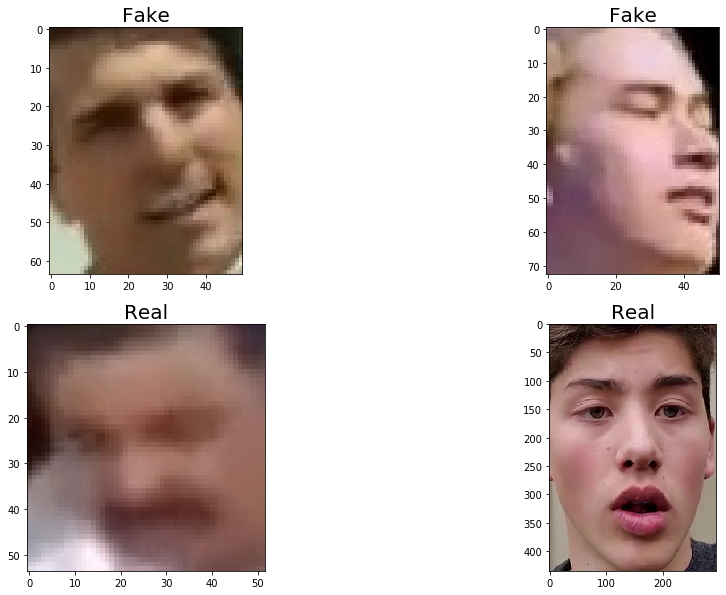

In [10]:
# Push CTRL + ENTER for update
rand_fake = len(train_data['image_path'][train_data['fake']==1])
rand_real = len(train_data['image_path'][train_data['real']==1])

img_fake_1= plt.imread(train_data['image_path'][train_data['fake']==1].iloc[np.random.randint(rand_fake)])
img_fake_2= plt.imread(train_data['image_path'][train_data['fake']==1].iloc[np.random.randint(rand_fake)])
img_real_1= plt.imread(train_data['image_path'][train_data['real']==1].iloc[np.random.randint(rand_real)])
img_real_2= plt.imread(train_data['image_path'][train_data['real']==1].iloc[np.random.randint(rand_real)])

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(2, 2, 1)
ax.imshow(img_fake_1)
ax.set_title('Fake', fontsize = 20)

ax = fig.add_subplot(2, 2, 2)
ax.imshow(img_fake_2)
ax.set_title('Fake', fontsize = 20)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(img_real_1)
ax.set_title('Real', fontsize = 20)

ax = fig.add_subplot(2, 2, 4)
ax.imshow(img_real_2)
ax.set_title('Real', fontsize = 20)

## VALIDATION SET

In [11]:
data_dir = [["/home/umit/xDataset/Sentinel-img/valid-real",1812],
            ]

In [12]:
valid_balance_real_full = None
for x in data_dir:
    
    _dir = x[0]
    sampleNum = x[1]
    
    data_samples = []
    valid_data_real = []
    
    # JPEG
    _list_jpeg = glob.glob(_dir + '/*.jpeg')
    data_samples += _list_jpeg
    # JPG
    _list_jpg = glob.glob(_dir + '/*.jpg')
    data_samples += _list_jpg
    # PNG
    _list_png = glob.glob(_dir + '/*.png')
    data_samples += _list_png
    
    valid_data_real = pd.DataFrame(data_samples,columns = ['image_path'])
    valid_data_real['real'] = 1
    valid_data_real['fake'] = 0
    
    if valid_balance_real_full is None:
        valid_balance_real_full = valid_data_real.sample(n=sampleNum, random_state=1,replace=False)
    else:
        valid_balance_real_full = pd.concat([valid_balance_real_full, 
                                       valid_data_real.sample(n=sampleNum, random_state=1,replace=False)],
                                       ignore_index=True)

In [13]:
valid_balance_real_full.head()

,image_path,real,fake
1141,/home/umit/xDataset/Sentinel-img/valid-real/va...,1,0
966,/home/umit/xDataset/Sentinel-img/valid-real/va...,1,0
707,/home/umit/xDataset/Sentinel-img/valid-real/va...,1,0
1208,/home/umit/xDataset/Sentinel-img/valid-real/va...,1,0
1308,/home/umit/xDataset/Sentinel-img/valid-real/va...,1,0


In [14]:
data_dir = [["/home/umit/xDataset/Sentinel-img/valid-fake",1336],
            ]

In [15]:
valid_balance_fake_full = None
for x in data_dir:
    
    _dir = x[0]
    sampleNum = x[1]
    
    data_samples = []
    valid_data_fake = []
    
    # JPEG
    _list_jpeg = glob.glob(_dir + '/*.jpeg')
    data_samples += _list_jpeg
    # JPG
    _list_jpg = glob.glob(_dir + '/*.jpg')
    data_samples += _list_jpg
    # PNG
    _list_png = glob.glob(_dir + '/*.png')
    data_samples += _list_png

    valid_data_fake = pd.DataFrame(data_samples,columns = ['image_path'])
    valid_data_fake['real'] = 0.0
    valid_data_fake['fake'] = 1.0
    
    if valid_balance_fake_full is None:
        valid_balance_fake_full = valid_data_fake.sample(n=sampleNum, random_state=1,replace=False)
    else:
        valid_balance_fake_full = pd.concat([valid_balance_fake_full, 
                                       valid_data_fake.sample(n=sampleNum, random_state=1,replace=False)],
                                       ignore_index=True)

In [16]:
valid_data = pd.concat([valid_balance_real_full, valid_balance_fake_full],ignore_index=True)
valid_data.head()

,image_path,real,fake
0,/home/umit/xDataset/Sentinel-img/valid-real/va...,1.0,0.0
1,/home/umit/xDataset/Sentinel-img/valid-real/va...,1.0,0.0
2,/home/umit/xDataset/Sentinel-img/valid-real/va...,1.0,0.0
3,/home/umit/xDataset/Sentinel-img/valid-real/va...,1.0,0.0
4,/home/umit/xDataset/Sentinel-img/valid-real/va...,1.0,0.0


## HYPERPARAMETER

In [17]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 8e-4

TRAIN_START = True
TRAIN_SIZE = train_data['image_path'].shape[0]
VALID_SIZE = valid_data['image_path'].shape[0]
MODEL_NAME = 'efficientnet-b1'
#MODEL_NAME = 'efficientnet-b5'

IMAGE_SIZE = EfficientNet.get_image_size(MODEL_NAME)
print(IMAGE_SIZE)

device = 'cuda:0'

START_EPOCH = 0
RESUME_EPOCH = 0 # LOAD EPOCH - CONTINUE +1
LOAD_MODEL_CHECKPOINT = False
LOAD_MODEL_CHECKPOINT_PATH = './checkpoint/epoch-%d.pth' %RESUME_EPOCH

TEST_BATCH_SIZE = 100
LOAD_MODEL_DEPLOY_NUMBER = 1
LOAD_MODEL_DEPLOY = False  
LOAD_MODEL_DEPLOY_PATH = './checkpoint/deploy-%d' %LOAD_MODEL_DEPLOY_NUMBER

240


## MODEL

In [18]:
class DeepFakeTrainDataset(Dataset):
    
    def __init__(self, image_paths, labels):
        
        self.paths = image_paths
        self.labels = labels
        
        self.transform = Compose([
            HorizontalFlip(p=0.5),
            RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, scale=(0.5, 1), p=0.5),
            Resize(IMAGE_SIZE, IMAGE_SIZE, always_apply=True),
            Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
            ToTensor()]) #normalized for pretrained network
                                              
    def __len__(self):
        return self.paths.shape[0]
    
    def __getitem__(self, i): 
        
        image_bgr = cv2.imread(self.paths[i])
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        image = self.transform(image = image)['image']
        
        label = torch.tensor(np.argmax(self.labels.loc[i,:].values))
         
        return image, label

In [19]:
class DeepFakeValidDataset(Dataset):
    
    def __init__(self, image_paths, labels):
        
        self.paths = image_paths
        self.labels = labels
        
        self.transform = Compose([
            Resize(IMAGE_SIZE,IMAGE_SIZE, always_apply=True),
            Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
            ToTensor()]) #normalized for pretrained network 
        
    def __len__(self):
        return self.paths.shape[0]
    
    def __getitem__(self, i): 
        
        image_bgr = cv2.imread(self.paths[i])
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        image = self.transform(image = image)['image']
        
        label = torch.tensor(np.argmax(self.labels.loc[i,:].values))
        
        return image, label

In [20]:
def train_fn(net, loader):
    
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    step_loss = []
    step_accuracy = []
    
    imgNum = 0
    
    pbar = tqdm(total = len(loader), desc='Training')

    for i, (images, labels) in enumerate(loader):
        
        images, labels = images.to(device), labels.to(device)
        net.train()
        optimizer.zero_grad()
        # forward
        predictions = net(images)
        # loss
        loss = loss_fn(predictions, labels)
        # backpropagation
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        #from IPython.core.debugger import Tracer; Tracer()() 
        
        running_loss += loss.item()*labels.shape[0]
        imgNum = imgNum + labels.shape[0]
        
        labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
        preds_for_acc = np.concatenate((preds_for_acc, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
            
        pbar.update()
        
    accuracy = accuracy_score(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/TRAIN_SIZE, accuracy

def valid_fn(net, loader):
    
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total = len(loader), desc='Validation')
    
    with torch.no_grad():
        
        for _, (images, labels) in enumerate(loader):
            
            images, labels = images.to(device), labels.to(device)
            net.eval()
            
            predictions = net(images)
            loss = loss_fn(predictions, labels)
            
            running_loss += loss.item()*labels.shape[0]
            labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
            preds_for_acc = np.concatenate((preds_for_acc, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
            
            pbar.update()
            
        accuracy = accuracy_score(labels_for_acc, preds_for_acc)
        conf_mat = confusion_matrix(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/VALID_SIZE, accuracy, conf_mat

In [21]:
train_dataset = DeepFakeTrainDataset(train_data['image_path'], train_data.loc[:, ['real','fake']])
trainloader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 2)

valid_dataset = DeepFakeValidDataset(valid_data['image_path'], valid_data.loc[:, ['real','fake']])
validloader = DataLoader(valid_dataset, shuffle=False, batch_size = TEST_BATCH_SIZE, num_workers = 2)

In [22]:
model = EfficientNet.from_pretrained(MODEL_NAME) 
num_ftrs = model._fc.in_features
model._fc = nn.Sequential(nn.Linear(num_ftrs,1000,bias=True),
                          nn.ReLU(),
                          nn.Dropout(p=0.5),
                          nn.Linear(1000,2, bias = True))

# summary(model, input_size=(3, 224, 224))
model.to(device)
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()
# loss_fn = torch.nn.BCELoss() # No Sigmoid
# loss_fn = torch.nn.BCEWithLogitsLoss() #  Sigmoid +  torch.nn.BCELoss()

Loaded pretrained weights for efficientnet-b1


In [23]:
#%matplotlib inline

train_loss = []
valid_loss = []
train_acc = []
val_acc = []

if LOAD_MODEL_CHECKPOINT:
    loaded_checkpoint = torch.load(LOAD_MODEL_CHECKPOINT_PATH)
    START_EPOCH = loaded_checkpoint["epoch"]
    model.load_state_dict(loaded_checkpoint["model_state_dict"])
    optimizer.load_state_dict(loaded_checkpoint["optimizer_state_dict"])
    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, 
                                                num_training_steps=num_train_steps,
                                                last_epoch=loaded_checkpoint["epoch"])
print("START_EPOCH = " + str(START_EPOCH))
if TRAIN_START:
    for epoch in range(START_EPOCH+1, NUM_EPOCHS+1):

        tl, ta = train_fn(model, loader = trainloader)
        vl, va, conf_mat = valid_fn(model, loader = validloader)
        train_loss.append(tl)
        valid_loss.append(vl)
        train_acc.append(ta)
        val_acc.append(va)

        # model save for checkpoint
        if epoch%1==0:

            checkpoint = {
                "epoch":epoch,
                "model_state_dict":model.state_dict(),
                "optimizer_state_dict":optimizer.state_dict()}
            path = './checkpoint/epoch-' + str(epoch) + '.pth'
            torch.save(checkpoint,path)

        # model save for deploy 
        if epoch%1==0:

            model_save_path = "./checkpoint/deploy-%d" % epoch
            with open(model_save_path, 'wb') as f:
                torch.save(model.state_dict(), f)

        printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl) + ', Train acc: ' + str(ta) + ', Val acc: ' + str(va)
        tqdm.write(printstr)

START_EPOCH = 0



Epoch: 1, Train loss: 0.4306984350376085, Val loss: 0.48771811270047327, Train acc: 0.7853953026794575, Val acc: 0.7970139771283354



Epoch: 2, Train loss: 0.16765445672909707, Val loss: 0.5953202529619844, Train acc: 0.9345021501819385, Val acc: 0.8325921219822109



Epoch: 3, Train loss: 0.11957553194806822, Val loss: 1.3265401104316021, Train acc: 0.9540191862388356, Val acc: 0.806861499364676



Epoch: 4, Train loss: 0.1130431232184635, Val loss: 0.6978178959448729, Train acc: 0.9593946410850149, Val acc: 0.7598475222363406



Epoch: 5, Train loss: 0.10124061066624032, Val loss: 0.9973264886054484, Train acc: 0.9641085014885875, Val acc: 0.7716010165184244



Epoch: 6, Train loss: 0.09869662118601831, Val loss: 0.4567275445676365, Train acc: 0.9676645716175984, Val acc: 0.8103557814485387



Epoch: 7, Train loss: 0.08134483219701409, Val loss: 0.7427290171536285, Train acc: 0.9715514389679126, Val acc: 0.806861499364676



Epoch: 8, Train loss: 0.06626548028353564, Val loss: 0.480045813806781, Train acc: 0.9752729077075752, Val acc: 0.8427573062261754



Epoch: 9, Train loss: 0.05858984164397004, Val loss: 0.8434789238504715, Train acc: 0.9813099569963613, Val acc: 0.8103557814485387



Epoch: 10, Train loss: 0.041670609337040185, Val loss: 1.3663016196146247, Train acc: 0.9853622229573271, Val acc: 0.7592121982210928



Epoch: 11, Train loss: 0.034043632479759785, Val loss: 0.7447058411535192, Train acc: 0.9882566986437314, Val acc: 0.8335451080050826



Epoch: 12, Train loss: 0.027635159347116394, Val loss: 0.6442090242608832, Train acc: 0.990985775719484, Val acc: 0.8370393900889453



Epoch: 13, Train loss: 0.02155271895161115, Val loss: 0.6286256932280722, Train acc: 0.9937975521005623, Val acc: 0.8246505717916137



Epoch: 14, Train loss: 0.012589159005716211, Val loss: 0.7727477429706835, Train acc: 0.9952861395964274, Val acc: 0.8424396442185514



Epoch: 15, Train loss: 0.014001111811418538, Val loss: 0.592565932676783, Train acc: 0.9949553423751241, Val acc: 0.8446632782719187



Epoch: 16, Train loss: 0.006802815489222262, Val loss: 0.6452889820179764, Train acc: 0.9982633145881574, Val acc: 0.8589580686149937



Epoch: 17, Train loss: 0.006814291549742862, Val loss: 0.5695185270326111, Train acc: 0.9977671187562025, Val acc: 0.863722998729352



Epoch: 18, Train loss: 0.0028975068699574518, Val loss: 0.6763616212214115, Train acc: 0.9990903076414158, Val acc: 0.852287166454892



Epoch: 19, Train loss: 0.004189011773011985, Val loss: 0.6881809313385127, Train acc: 0.9986768111147867, Val acc: 0.8538754764930114



Epoch: 20, Train loss: 0.003482342540261296, Val loss: 0.6804944546053037, Train acc: 0.9986768111147867, Val acc: 0.8513341804320204


## STATISTICS
https://github.com/taylover-pei/SSDG-CVPR2020/blob/master/utils/statistic.py

In [24]:
def eval_state(probs, labels, thr):
    predict = probs >= thr
    TN = np.sum((labels == 0) & (predict == False))
    FN = np.sum((labels == 1) & (predict == False))
    FP = np.sum((labels == 0) & (predict == True))
    TP = np.sum((labels == 1) & (predict == True))
    return TN, FN, FP, TP

In [25]:
def calculate(probs, labels):
    TN, FN, FP, TP = eval_state(probs, labels, 0.5)
    APCER = 1.0 if (FP + TN == 0) else FP / float(FP + TN)
    NPCER = 1.0 if (FN + TP == 0) else FN / float(FN + TP)
    ACER = (APCER + NPCER) / 2.0
    ACC = (TP + TN) / (TN + FN + FP + TP) #labels.shape[0]
    return APCER, NPCER, ACER, ACC

In [26]:
def calculate_threshold(probs, labels, threshold):
    TN, FN, FP, TP = eval_state(probs, labels, threshold)
    ACC = (TP + TN) / (TN + FN + FP + TP) #labels.shape[0]
    return ACC

In [27]:
def get_threshold(probs, grid_density):
    Min, Max = min(probs), max(probs)
    thresholds = []
    for i in range(grid_density + 1):
        thresholds.append(0.0 + i * 1.0 / float(grid_density))
    thresholds.append(1.1)
    return thresholds

In [28]:
def get_EER_states(probs, labels, grid_density = 10000):
    thresholds = get_threshold(probs, grid_density)
    min_dist = 1.0
    min_dist_states = []
    FRR_list = []
    FAR_list = []
    for thr in thresholds:
        TN, FN, FP, TP = eval_state(probs, labels, thr)
        if(FN + TP == 0):
            FRR = TPR = 1.0
            FAR = FP / float(FP + TN)
            TNR = TN / float(TN + FP)
        elif(FP + TN == 0):
            TNR = FAR = 1.0
            FRR = FN / float(FN + TP)
            TPR = TP / float(TP + FN)
        else:
            FAR = FP / float(FP + TN)
            FRR = FN / float(FN + TP)
            TNR = TN / float(TN + FP)
            TPR = TP / float(TP + FN)
        dist = math.fabs(FRR - FAR)
        FAR_list.append(FAR)
        FRR_list.append(FRR)
        if dist <= min_dist:
            min_dist = dist
            min_dist_states = [FAR, FRR, thr]
    EER = (min_dist_states[0] + min_dist_states[1]) / 2.0
    thr = min_dist_states[2]
    return EER, thr, FRR_list, FAR_list

In [29]:
def get_HTER_at_thr(probs, labels, thr):
    TN, FN, FP, TP = eval_state(probs, labels, thr)
    if (FN + TP == 0):
        FRR = 1.0
        FAR = FP / float(FP + TN)
    elif(FP + TN == 0):
        FAR = 1.0
        FRR = FN / float(FN + TP)
    else:
        FAR = FP / float(FP + TN)
        FRR = FN / float(FN + TP)
    HTER = (FAR + FRR) / 2.0
    return HTER

## TEST

In [30]:
data_dir = [["/home/umit/xDataset/Sentinel-img/test-real",5626],
            ]

In [31]:
test_balance_real_full = None
for x in data_dir:
    
    _dir = x[0]
    sampleNum = x[1]
    
    data_samples = []
    test_data_real = []
    
    # JPEG
    _list_jpeg = glob.glob(_dir + '/*.jpeg')
    data_samples += _list_jpeg
    # JPG
    _list_jpg = glob.glob(_dir + '/*.jpg')
    data_samples += _list_jpg
    # PNG
    _list_png = glob.glob(_dir + '/*.png')
    data_samples += _list_png
    
    test_data_real = pd.DataFrame(data_samples,columns = ['image_path'])
    test_data_real['real'] = 1
    test_data_real['fake'] = 0
    
    if test_balance_real_full is None:
        test_balance_real_full = test_data_real.sample(n=sampleNum, random_state=1,replace=False)
    else:
        test_balance_real_full = pd.concat([test_balance_real_full, 
                                       test_data_real.sample(n=sampleNum, random_state=1,replace=False)],
                                       ignore_index=True)

In [32]:
test_balance_real_full.head()

,image_path,real,fake
5137,/home/umit/xDataset/Sentinel-img/test-real/tes...,1,0
3516,/home/umit/xDataset/Sentinel-img/test-real/tes...,1,0
5571,/home/umit/xDataset/Sentinel-img/test-real/tes...,1,0
5409,/home/umit/xDataset/Sentinel-img/test-real/tes...,1,0
3187,/home/umit/xDataset/Sentinel-img/test-real/tes...,1,0


In [33]:
data_dir = [["/home/umit/xDataset/Sentinel-img/test-fake",4865],
            ]

In [34]:
test_balance_fake_full = None
for x in data_dir:
    
    _dir = x[0]
    sampleNum = x[1]
    
    data_samples = []
    test_data_fake = []
    
    # JPEG
    _list_jpeg = glob.glob(_dir + '/*.jpeg')
    data_samples += _list_jpeg
    # JPG
    _list_jpg = glob.glob(_dir + '/*.jpg')
    data_samples += _list_jpg
    # PNG
    _list_png = glob.glob(_dir + '/*.png')
    data_samples += _list_png

    test_data_fake = pd.DataFrame(data_samples,columns = ['image_path'])
    test_data_fake['real'] = 0.0
    test_data_fake['fake'] = 1.0
    
    if test_balance_fake_full is None:
        test_balance_fake_full = test_data_fake.sample(n=sampleNum, random_state=1,replace=False)
    else:
        test_balance_fake_full = pd.concat([test_balance_fake_full, 
                                       test_data_fake.sample(n=sampleNum, random_state=1,replace=False)],
                                       ignore_index=True)

In [35]:
test_balance_fake_full.head()

,image_path,real,fake
600,/home/umit/xDataset/Sentinel-img/test-fake/tes...,0.0,1.0
3033,/home/umit/xDataset/Sentinel-img/test-fake/tes...,0.0,1.0
248,/home/umit/xDataset/Sentinel-img/test-fake/tes...,0.0,1.0
1892,/home/umit/xDataset/Sentinel-img/test-fake/tes...,0.0,1.0
3438,/home/umit/xDataset/Sentinel-img/test-fake/tes...,0.0,1.0


In [36]:
test_data = pd.concat([test_balance_real_full, test_balance_fake_full],ignore_index=True)
len(test_data)

10491

In [37]:
class DeepFakeTestDataset(Dataset):
    
    def __init__(self, image_paths, labels):
        
        self.paths = image_paths
        self.labels = labels
        
        self.transform = Compose([Resize(IMAGE_SIZE,IMAGE_SIZE, always_apply=True),
                                       Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
                                       ToTensor()]) #normalized for pretrained network
        
    def __len__(self):
        return self.paths.shape[0]
    
    def __getitem__(self, i):
        
        image_bgr = cv2.imread(self.paths[i])
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)['image']
        
        label = torch.tensor(np.argmax(self.labels.loc[i,:].values))

        return image, label

In [38]:
test_dataset = DeepFakeTestDataset(test_data['image_path'], test_data.loc[:, ['real','fake']])
testloader = DataLoader(test_dataset, shuffle=False, batch_size = TEST_BATCH_SIZE, num_workers = 2)

In [39]:
if LOAD_MODEL_DEPLOY:
    # model load for deploy
    device='cuda:0'
    model.load_state_dict(torch.load(open(LOAD_MODEL_DEPLOY_PATH, 'rb'), map_location=device))
    model.eval()

In [40]:
#from IPython.core.debugger import Tracer; Tracer()()
def test_fn(net, loader):

    preds_pair = []
    score_max = []
    labels_for_acc = []
    preds_for_acc = []
    
    pbar = tqdm(total = len(loader), desc='Test')
    
    with torch.no_grad():

        for i, (images, labels) in enumerate(loader):
            
            images, labels = images.to(device), labels.to(device)
            net.eval()
            predictions = net(images)
            predictions_normalize = softmax(predictions.cpu().detach().numpy(),1)
            
            # assign initial values
            if i==0:
                preds_pair = predictions_normalize
            else:
                preds_pair = np.concatenate((preds_pair, predictions_normalize), 0)
            
            labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
            
            pbar.update()
             
    pbar.close()
    
    return preds_pair, labels_for_acc

In [41]:
np.set_printoptions(precision=3,suppress=True,threshold=5)

subs = []
repeat = 1
for i in range(repeat): #average over 3 runs
    
    preds_pair, labels_for_acc = test_fn(model, testloader)
    output = pd.DataFrame(preds_pair, columns = ['predict_real','predict_fake'])
    output.drop(0, inplace = True)
    output.reset_index(drop=True,inplace=True)
    subs.append(output)

sub_1 = sum(subs)/repeat

In [42]:
score_real = preds_pair[:,0] # real = 1, fake = 0
preds_for_acc = np.argmax(preds_pair, 1)
# Convert Real = 1, Fake = 0 
preds_for_acc = 1 - preds_for_acc
labels_for_acc = 1 - labels_for_acc

In [43]:
accuracy = accuracy_score(labels_for_acc, preds_for_acc)
conf_mat = confusion_matrix(labels_for_acc, preds_for_acc)

print("Test Accuracy = " + str(accuracy))

TP = conf_mat[1,1] # Real True
FN = conf_mat[1,0] # Real False
TN = conf_mat[0,0] # Fake True
FP = conf_mat[0,1] # Fake False

APCER = 1.0 if (FP + TN == 0) else FP / float(FP + TN)
NPCER = 1.0 if (FN + TP == 0) else FN / float(FN + TP) # BPCER
ACER = (APCER + NPCER) / 2.0
ACC = (TP + TN) / (TP + TN + FP + FN)
print("APCER = " + str(APCER))
print("NPCER = " + str(NPCER))
print("ACER = " + str(ACER))
print("ACC = " + str(ACC))

print(TN, FN, FP, TP)

Test Accuracy = 0.839004861309694
APCER = 0.25837615621788285
NPCER = 0.0767863490934945
ACER = 0.16758125265568868
ACC = 0.839004861309694
3608 432 1257 5194


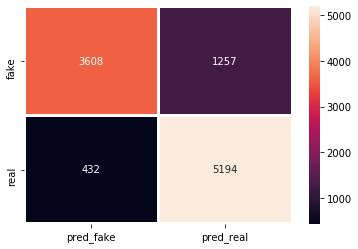

In [44]:
predict_labels = ['pred_fake','pred_real']
labels = ['fake','real']
sns.heatmap(conf_mat, xticklabels=predict_labels, yticklabels=labels, linewidths=2, annot=True, fmt="d")

In [45]:
def eval_state(probs, labels, thr):
    predict = probs >= thr
    TN = np.sum((labels == 0) & (predict == False))
    FN = np.sum((labels == 1) & (predict == False))
    FP = np.sum((labels == 0) & (predict == True))
    TP = np.sum((labels == 1) & (predict == True))
    return TN, FN, FP, TP

In [46]:
TN, FN, FP, TP = eval_state(score_real,labels_for_acc,0.5)
print(TN, FN, FP, TP)

3608 432 1257 5194


In [47]:
APCER, NPCER, ACER, ACC = calculate(score_real, labels_for_acc)
APCER, NPCER, ACER, ACC 

(0.25837615621788285,
 0.0767863490934945,
 0.16758125265568868,
 0.839004861309694)

In [48]:
EER, thr, FRR_list, FAR_list = get_EER_states(score_real, labels_for_acc, grid_density = 10000)
EER, thr

(0.15793931712585343, 0.9883)

In [49]:
HTER = get_HTER_at_thr(score_real, labels_for_acc, thr)
HTER

0.15793931712585343

In [50]:
ACC_thr = calculate_threshold(score_real, labels_for_acc, thr)
ACC_thr

0.842055094843199

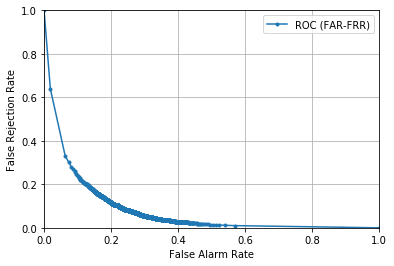

In [51]:
plt.plot(FAR_list, FRR_list, marker='.', label='ROC (FAR-FRR)')
# axis labels
plt.xlabel('False Alarm Rate')
plt.ylabel('False Rejection Rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
# show the legend
plt.legend()
# save and show plot
plt.savefig('./results/Test Results.png')
plt.show()

In [52]:
sub_1['real'] = test_data['real']
sub_1['fake'] = test_data['fake']
sub_1.head()

,predict_real,predict_fake,real,fake
0,0.999965,3.501520e-05,1.0,0.0
1,0.985192,1.480773e-02,1.0,0.0
2,0.025589,9.744110e-01,1.0,0.0
3,1.000000,4.836811e-08,1.0,0.0
4,1.000000,1.354459e-14,1.0,0.0


In [53]:
sub = sub_1.copy()
sub['image_path'] = test_data['image_path']
sub = sub[['image_path','predict_real','predict_fake','real','fake']]

sub.to_csv('./results/submission.csv', index = False)

In [54]:
sub

,image_path,predict_real,predict_fake,real,fake
0,/home/umit/xDataset/Sentinel-img/test-real/tes...,0.999965,3.501520e-05,1.0,0.0
1,/home/umit/xDataset/Sentinel-img/test-real/tes...,0.985192,1.480773e-02,1.0,0.0
2,/home/umit/xDataset/Sentinel-img/test-real/tes...,0.025589,9.744110e-01,1.0,0.0
3,/home/umit/xDataset/Sentinel-img/test-real/tes...,1.000000,4.836811e-08,1.0,0.0
4,/home/umit/xDataset/Sentinel-img/test-real/tes...,1.000000,1.354459e-14,1.0,0.0
...,...,...,...,...,...
10485,/home/umit/xDataset/Sentinel-img/test-fake/tes...,0.000003,9.999971e-01,0.0,1.0
10486,/home/umit/xDataset/Sentinel-img/test-fake/tes...,0.041386,9.586145e-01,0.0,1.0
10487,/home/umit/xDataset/Sentinel-img/test-fake/tes...,0.815397,1.846031e-01,0.0,1.0
10488,/home/umit/xDataset/Sentinel-img/test-fake/tes...,0.476767,5.232332e-01,0.0,1.0


## Clear GPU memory

In [55]:
CLEAR_MEMORY = False
if CLEAR_MEMORY:
    del model
    del optimizer
    del scheduler
    torch.cuda.empty_cache()